# The Gibbs Sampler for the Normal Distribution

We implement a Gibbs sampler for a normal model with conditionally conjugate priors for the mean and precision. This is example 26.3.2 in Lange. See Section 26.3 of Lange or Section 11.1 of Bayesian Data Analysis by Gelman for an introduction to Gibbs sampling.

Suppose we obtain observations $X_1,\ldots,X_n \sim N(\mu,1/\tau)$. $\tau$ is called the precision and equals 1 over the variance. This is an alternative way of parameterizing the normal distribution.


## Numerical Example

### Simulate Data

We simulate $n$ observations from a normal with mean $\mu_t$ (the subscript t is for true) and precision $\tau = 1$.

In [202]:
import numpy as np
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
%matplotlib inline
plt.style.use('ggplot')

In [203]:
n = 10
mut = 1.0
taut = 3.0
x = norm.rvs(mut,scale=1.0/np.sqrt(taut),size=n)

In [204]:
print(np.mean(x))
print(1.0/np.var(x))

1.361282443084677
2.49577266119848


We pretend we do not know $\mu_t$ or $\tau_t$. In a Bayesian framework we put priors $\pi(\mu,\tau)$ to represent our uncertainty about these parameters. We chose independent priors so $\pi(\mu,\tau) = \pi(\mu)\pi(\tau)$. We make the prior for $\mu$ normal with mean $0$ and precision $\omega$. We make the prior for $\tau$ a $Gamma(\alpha,\beta)$. Thus the posterior is
$$
\pi(\mu,\tau) \propto f(x|\mu,\tau) \pi(\mu)\pi(\tau)
$$

### Gamma Prior on $\tau$

In [205]:
## chosen to represent our prior belief about tau
alpha = 9.0
beta = 0.5

In [168]:
taur = gamma.rvs(alpha,scale=beta,size=1000)

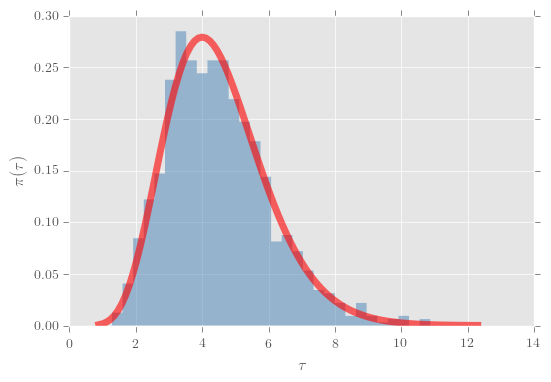

In [169]:
fig, ax = plt.subplots(1, 1)
tau = np.linspace(gamma.ppf(0.0001, alpha, scale=beta),
              gamma.ppf(0.9999, alpha, scale=beta), 100)
ax.plot(tau, gamma.pdf(tau, alpha, scale=beta),
         'r-', lw=5, alpha=0.6, label='gamma prior');
plt.hist(taur, bins=30, normed=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel(r'\tau');
plt.ylabel(r'$\pi(\tau)$');

### Normal Prior on $\mu$

In [207]:
## chosen to represent our prior belief about mu
## we could make omega very small (equivalent to making variance very large)
## to represent that there is a lot of initial uncertainty about mu
omega = 2.0 # this is 1/var

In [171]:
mur = norm.rvs(0.0,scale=1.0/np.sqrt(omega),size=1000)

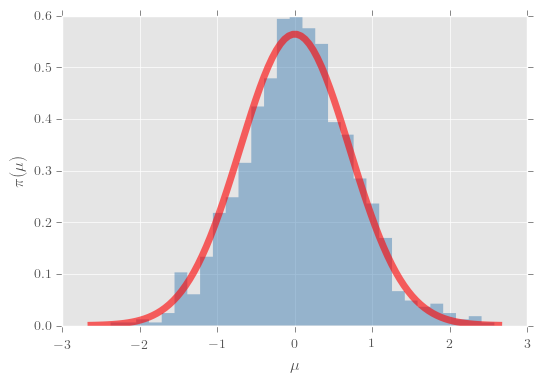

In [172]:
fig, ax = plt.subplots(1, 1)
mu = np.linspace(norm.ppf(0.0001, 0.0, scale=1/np.sqrt(omega)),
              norm.ppf(0.9999, 0.0, scale=1/np.sqrt(omega)), 100)
ax.plot(mu, norm.pdf(mu, 0.0, scale=1/np.sqrt(omega)),
         'r-', lw=5, alpha=0.6, label='normal prior');
plt.hist(mur, bins=30, normed=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel(r'\mu');
plt.ylabel(r'$\pi(\mu)$');

### Joint Prior

In [173]:
def joint_prior(mu,tau):
    return norm.pdf(mu, 0.0, scale=1/np.sqrt(omega))*gamma.pdf(tau, alpha, scale=beta)

In [174]:
mug, taug = np.meshgrid(mu,tau)

In [175]:
mug.shape

(100, 100)

In [176]:
XYpairs = np.vstack([ mug.reshape(-1), taug.reshape(-1) ])
Z = np.apply_along_axis(lambda z: joint_prior(z[0],z[1]),0,XYpairs)
Z = Z.reshape((100,100))

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


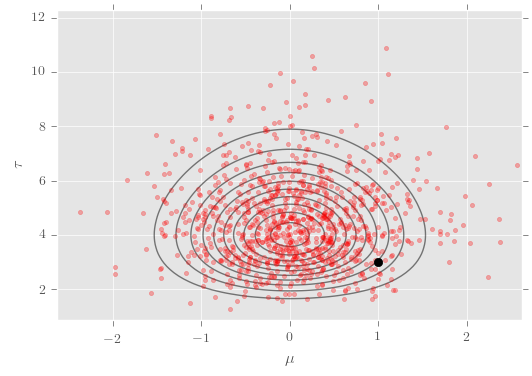

In [177]:
### PLOT 1: contours
plt.contour(mug, taug, Z,10, colors='black',alpha=0.5);
plt.plot(mur,taur,'.',color='red',alpha=0.3);
plt.plot(mut,taut,'o',color='black',alpha=1.0);
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau$');

### Posterior Contours

We plot contours of the posterior distribution. This is only feasible in one or two dimensions. The Gibbs sampler (below) will work for much higher dimensional problems.

In [178]:
def post(mu,tau):
    like = np.prod(norm.pdf(x,loc=mu,scale=1/np.sqrt(tau)))
    pimu = norm.pdf(mu, 0.0, scale=1/np.sqrt(omega))
    pitau = gamma.pdf(tau, alpha, scale=beta)
    return like*pimu*pitau ## = f(x|mu,tau)pi(mu)pi(tau)

In [179]:
XYpairs = np.vstack([ mug.reshape(-1), taug.reshape(-1) ])
Z = np.apply_along_axis(lambda z: post(z[0],z[1]),0,XYpairs)
Z = Z.reshape((100,100))

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


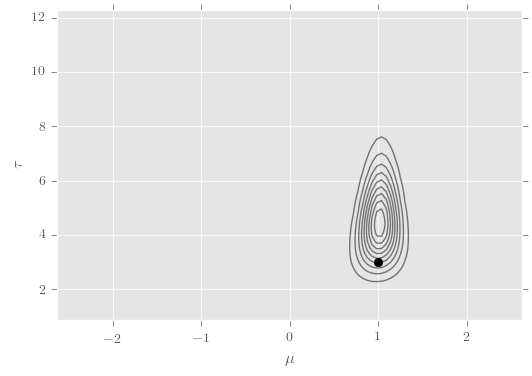

In [180]:
### PLOT 1: contours
plt.contour(mug, taug, Z,10, colors='black',alpha=0.5);
##plt.plot(mur,taur,'.',color='red',alpha=0.3);
plt.plot(mut,taut,'o',color='black',alpha=1.0);
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau$');

## Gibbs Sampler

The Gibbs sampler iteratively updates the parameters $\mu$ and $\tau$ based on their conditional distributions $\pi(\mu|\tau,x)$ and $\pi(\tau|\mu,x)$. The method is most effective when we can sample from these conditional densities in closed form. This is the case whenever we choose priors which are conditionally conjugate i.e. conjugate assuming all other parameters known. This is the case with the priors we chose. Specifically for $\tau$ we have
\begin{align*}
\pi(\tau|\mu,x) &= f(x|\mu,\tau)\pi(\tau)\\
&= \prod_{i=1}^n \left(\frac{\tau^{1/2}}{\sqrt{2\pi}} e^{-(x_i - \mu)^2\tau/2}\right) \frac{\tau^{\alpha-1}}{\Gamma(\alpha)\beta^\alpha}e^{-\tau/\beta}\\
&\propto \tau^{n/2 + \alpha - 1}e^{-\tau(\sum (x_i - \mu)^2 /2 + \beta^{-1})}\\
&\propto Gamma\left(\alpha' = \frac{n}{2} + \alpha, \beta' = \left(\sum (x_i - \mu)^2 /2 + \beta^{-1}\right)^{-1}\right)
\end{align*}

Similar calculations show
$$ \pi(\mu|x,\tau) = N\left(\frac{n\tau\bar{x}}{\omega + n\tau}, \frac{1}{\omega + n\tau}\right)$$

With Gibbs, we iteratively draw from each of these distributions.

In [208]:
Niter = 10000
chain = np.zeros(Niter*2).reshape((Niter,2))
for ii in np.arange(Niter-1):
    chain[ii+1,0] = gamma.rvs(n/2 + alpha,
                              scale=(np.sum((x-chain[ii,1])**2)/2 + (1.0/beta))**-1,size=1)
    chain[ii+1,1] = norm.rvs(n*chain[ii+1,0]*np.mean(x) / (omega + n*chain[ii+1,0]),
                             scale=np.sqrt(1.0/(omega + n*chain[ii+1,0])),size=1)

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


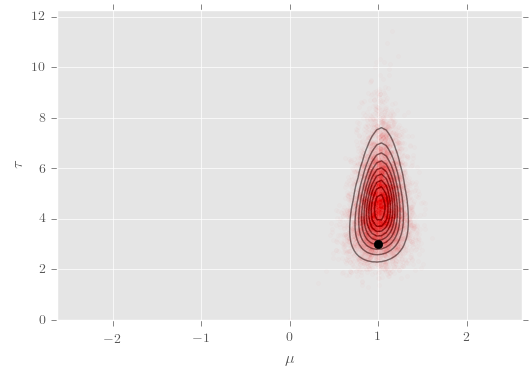

In [186]:
### PLOT 1: contours
plt.contour(mug, taug, Z,10, colors='black',alpha=0.5);
plt.plot(chain[:,1],chain[:,0],'.',color='red',alpha=0.01);
plt.plot(mut,taut,'o',color='black',alpha=1.0);
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau$');

Looks good. Just as with Metropolis we should check that the chain has converged. We can do this by monitoring time series plots of the parameters and running multiple chains from overdispersed starting locations.

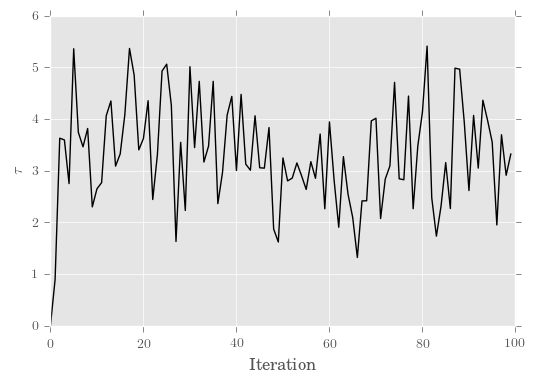

In [209]:
plt.plot(np.arange(100),chain[:100,0],color='black',alpha=1.0);
plt.xlabel("Iteration")
plt.ylabel(r'$\tau$');

The chain enters steady state very quickly due to the easy nature of this problem. We now look at the first `upto` iterations in $\mu$, $\tau$ space.

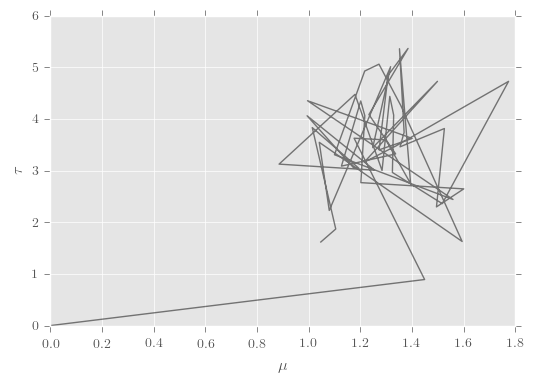

In [210]:
upto = 50
plt.plot(chain[:upto,1],chain[:upto,0],color='black',alpha=0.5);
##plt.plot(mut,taut,'o',color='black',alpha=1.0);
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\tau$');

We discard the first half of the iterations (the burn in period) and compute posterior means with the second half.

In [196]:
chain = chain[int(np.floor(Niter/2)):,:]

In [198]:
## Estimated precision
np.mean(chain[:,0])

4.601807704367812

In [199]:
## estimated standard deviation
np.mean(np.sqrt(1/chain[:,0]))

0.47922399872769383

In [200]:
## estimated mean mu
np.mean(chain[:,1])

1.015382930558676

In [201]:
## the MLE is
np.mean(x)

1.0621809594598284

The Bayesian point estimator for $\mu$, the posterior mean, is closer to $0$ than the MLE because the prior for $\mu$ was centered at $0$.

** Exercise: ** Start the chain from another location (other than 0,0) and monitor mixing.

** Exercise: ** Increase the sample size by a factor of 10 and rerun the code. What do you observe?

** Exercise: ** Write a Metropolis sampler for this problem.

## Gibbs and Metropolis Comparison and Summary

* In conditionally conjugate models, Gibbs does not have any tuning parameters. In contrast the variance of the proposal distribution must be tuned in Metropolis.
* For non-conditionally conjugate models it is possible to run Metropolis within Gibbs, where Metropolis chains are used to sampled conditionally at each step.
* Gibbs samplers can also be implemented which randomly choose which block of parameters to update (see Lange).